In [3]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [4]:
x_original=pd.read_csv('../../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../../_targelable4_withNa_AllColumns.txt')


x_original=x_original[['Unnamed: 0','L101300', 'SEX', 'L101700', 'L101200', 'S000300', 'L103300',
       'L100700', 'L103000', 'S000501', 'L190300', 'L103100', 'L190500',
                      'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24']]

y_original=y_original[['Unnamed: 0','L101300']]


print(x_original.shape)
print(y_original.shape)


(159381, 19)
(159381, 2)


In [5]:
# for index,col in enumerate(x_original.columns):
#     print(col,x_original[col].dropna().shape[0])

Prepare the data
============

In [6]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

print(data.shape)

(128718, 21)


In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(128718, 21)


In [8]:
print(data.shape)
print(data.columns)
data.head()

(128718, 21)
Index(['index', 'Unnamed: 0', 'L101300_x', 'SEX', 'L101700', 'L101200',
       'S000300', 'L103300', 'L100700', 'L103000', 'S000501', 'L190300',
       'L103100', 'L190500', 'FIELD_16', 'FIELD_23', 'FIELD_15', 'FIELD_22',
       'FIELD_17', 'FIELD_24', 'L101300_y'],
      dtype='object')


,index,Unnamed: 0,L101300_x,SEX,L101700,L101200,S000300,L103300,L100700,L103000,...,L190300,L103100,L190500,FIELD_16,FIELD_23,FIELD_15,FIELD_22,FIELD_17,FIELD_24,L101300_y
0,0,0,8.0,1.0,13.0,17.0,20.1,3.1,3.0,53.0,...,4.20,68.0,38.2,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1,1,1,9.0,1.0,14.0,21.0,19.7,3.3,3.0,53.0,...,4.24,71.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,2,2,10.0,1.0,15.0,19.0,20.2,3.4,3.8,41.0,...,4.26,72.0,38.4,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,3,3,12.0,1.0,10.0,15.0,24.8,2.8,3.7,58.0,...,4.20,64.0,40.3,0.0,0.0,0.0,0.0,0.0,0.0,12.0
4,4,4,12.0,1.0,12.0,16.0,25.5,2.9,3.4,50.0,...,3.92,58.0,38.6,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [9]:

x=data[['L101300_x', 'SEX', 'L101700', 'L101200', 'S000300', 'L103300',
       'L100700', 'L103000', 'S000501', 'L190300', 'L103100', 'L190500']]

y=data[['L101300_y']]

Check the correlation of the selected feature with the independent variables
=====

In [10]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.L101300_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [11]:
corval.y

y            1.000000
L101300_x    0.563288
L101700      0.367553
S000300      0.364531
L101200      0.343272
SEX          0.318386
L100700      0.315164
L190500      0.310254
L190300      0.309199
L103300      0.306357
L103000      0.280145
S000501      0.240527
L103100      0.236898
Name: y, dtype: float64

In [12]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [13]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [14]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [15]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [16]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [17]:
# x.columns

Random Forest Regressor
=============

In [18]:
ylable=y[['L101300_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [19]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.78392528 0.01303057 0.0224324  0.02700788 0.04880737 0.01406627
 0.01363593 0.02983481 0.00875327 0.00802385 0.01252456 0.01795781]


mean_squared_error 228.95868882558273
root mean_squared_error 15.13138092923388
mean_absolute_error 7.540912433453526
r2_score 0.4118951626783438


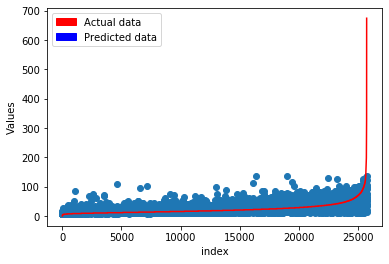

,t + 1,pred (t +1)
12237,289.0,97.767848
24483,291.0,50.521643
21944,307.0,57.648416
21634,314.0,135.817098
13725,327.0,122.239645
21179,405.0,22.722388
12004,444.0,41.386143
16423,453.0,36.416971
22556,666.0,13.897762
621,674.0,75.035729


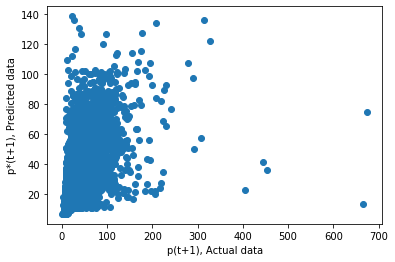

In [20]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [21]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [22]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [23]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[21:37:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [24]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 229.25807657396922
root mean_squared_error 15.141270639347585
mean_absolute_error 7.497676356216908
r2_score 0.41112615328208946


In [34]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [34]:
model= Sequential()
model.add(Dense(input_dim=34,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [35]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

W1003 23:42:09.332351 17432 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 14930 samples, validate on 3733 samples
Epoch 1/100
14930/14930 [==============================] - 1s 67us/step - loss: 521.5574 - mean_squared_error: 521.5574 - val_loss: 484.1793 - val_mean_squared_error: 484.1793
Epoch 2/100
14930/14930 [==============================] - 0s 25us/step - loss: 270.9792 - mean_squared_error: 270.9792 - val_loss: 284.2984 - val_mean_squared_error: 284.2984
Epoch 3/100
14930/14930 [==============================] - 0s 26us/step - loss: 259.8076 - mean_squared_error: 259.8076 - val_loss: 260.4897 - val_mean_squared_error: 260.4897
Epoch 4/100
14930/14930 [==============================] - 0s 25us/step - loss: 259.0042 - mean_squared_error: 259.0042 - val_loss: 294.8089 - val_mean_squared_error: 294.8089
Epoch 5/100
14930/14930 [==============================] - 0s 24us/step - loss: 256.1533 - mean_squared_error: 256.1533 - val_loss: 834.4343 - val_mean_squared_error: 834.4343
Epoch 6/100
14930/14930 [==============================] - 0s 25us/step

14930/14930 [==============================] - 0s 25us/step - loss: 236.3681 - mean_squared_error: 236.3681 - val_loss: 266.0871 - val_mean_squared_error: 266.0871
Epoch 48/100
14930/14930 [==============================] - 0s 24us/step - loss: 235.0131 - mean_squared_error: 235.0131 - val_loss: 271.8186 - val_mean_squared_error: 271.8186
Epoch 49/100
14930/14930 [==============================] - 0s 23us/step - loss: 233.8299 - mean_squared_error: 233.8299 - val_loss: 246.3295 - val_mean_squared_error: 246.3295
Epoch 50/100
14930/14930 [==============================] - 0s 25us/step - loss: 236.6574 - mean_squared_error: 236.6574 - val_loss: 246.3250 - val_mean_squared_error: 246.3250
Epoch 51/100
14930/14930 [==============================] - 0s 25us/step - loss: 234.6217 - mean_squared_error: 234.6217 - val_loss: 383.1526 - val_mean_squared_error: 383.1526
Epoch 52/100
14930/14930 [==============================] - 0s 24us/step - loss: 237.2909 - mean_squared_error: 237.2909 - val_l

In [36]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 496.1629233699221
root mean_squared_error 22.274714888633753
mean_absolute_error 7.946551557574413
r2_score 0.23412286875170862


,t + 1,pred (t +1)
0,40.0,23.159456
1,18.0,17.667181
2,16.0,12.740708
3,22.0,19.936028
4,17.0,11.952861
5,14.0,13.421432
6,8.0,15.275977
7,41.0,24.102568
8,10.0,12.210329
9,27.0,13.834530


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


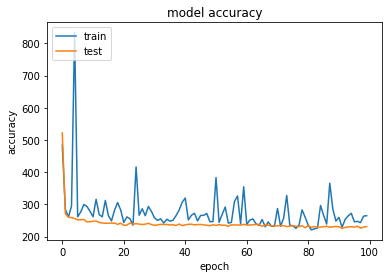

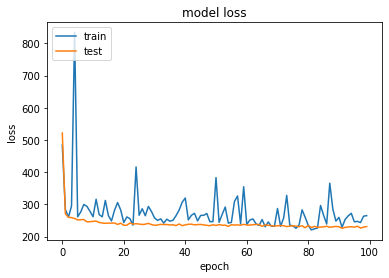

In [37]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

7.946551557574413
20.809018278446835
58.52978996999571


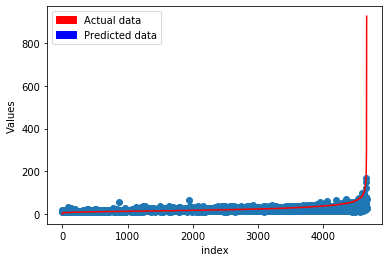

,t + 1,pred (t +1),diff
1754,1.0,18.915892,17.915892
3582,1.0,12.772871,11.772871
158,4.0,12.347008,8.347008
193,4.0,12.194701,8.194701
2865,4.0,11.420227,7.420227
688,5.0,12.265177,7.265177
1735,5.0,12.259502,7.259502
2672,5.0,12.263136,7.263136
1227,5.0,12.033879,7.033879
475,5.0,12.195220,7.195220


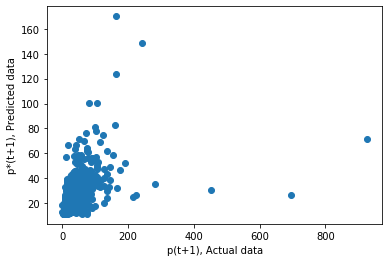

In [39]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)